# このノートでやった（できる）こと
### その日のレースのうち、イン逃げの可能性が高いものをリストアップ

#### 計算に用いたアルゴリズム
Logistic Regression

#### 計算に用いた特徴量
- 各レーサーのクラス
- 各レーサーの各枠における平均スタートタイム
- 各レーサーの連帯率
- 各モーターの2連率
- 各モーターの3連率
- 各ボートの2連率
- 各ボートの3連率

#### 目的変数
- 1枠: 1着になる (1) or ならない (0)
- 2-6枠: 3着以内にはいる (1) or 入らない (0)


### 結果
#### Logistic Regression結果
- Logistic_regression_1よりは全体的にいい結果になるが、まだ実用化にたるものとは言えない。ギャンブル性がある。
- regressionに使う結果を、半年分入れるよりも、1ヶ月分など短期にする方が予測精度が上がる可能性がある
#### bet結果


In [1]:
# 必要なモジュールのインポート

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import termcolor
from datetime import datetime

import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, '../conf/'))
sys.path.append(os.path.join(current_dir, '../crawl/'))
sys.path.append(os.path.join(current_dir, '../data_preparing/'))
sys.path.append(os.path.join(current_dir, 'analyzer_conf/'))

# my module
import loader
import boatrace_crawler_conf
import analyzer_conf

In [2]:
# 過去のレース結果をdfとして取得
the_merged_df = loader.main()
# dfをソート
the_merged_df = the_merged_df.sort_values(["date", "venue", "raceNumber"])
# print(the_merged_df["CS_frame_1_1"])

/Users/grice/mywork/boatrace/src/analyze/../data_preparing/loader.py:357: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  race_results_supplementary_df = pd.concat(race_results_supplementary_df_list)


In [3]:
"""

# test用にdfを期間で区切って小さくして使いたい時
from_dt = datetime(2019, 1, 1)
to_dt = datetime(2019, 9, 1)

the_merged_df = the_merged_df[(the_merged_df["date"] >= from_dt) & (the_merged_df["date"] <= to_dt)]

"""

'\n\n# test用にdfを期間で区切って小さくして使いたい時\nfrom_dt = datetime(2019, 1, 1)\nto_dt = datetime(2019, 9, 1)\n\nthe_merged_df = the_merged_df[(the_merged_df["date"] >= from_dt) & (the_merged_df["date"] <= to_dt)]\n\n'

In [4]:
# logistic regressionを利用した学習

def make_df_for_analyze(merged_df, fv_list, column_list_label, odds_list):
    """
    parameters
        fv_list: dfのうち、特徴量として用いるカラム名のリスト
        column_list_label: dfのうち、labelとして用いるカラム名のリスト
    """
    
    # 特徴量のdfを作成
    fv_df = merged_df[fv_list]
    
    # クラスカラムを，A1 =0, A2 = 1のように数字に変換する
    class_dict = {"A1": 0, "A2":1, "B1": 2, "B2": 3}
    for key, value in class_dict.items():
        fv_df.replace(key, value, inplace = True)

    # 会場名をbooleanに変換
    venue_df = pd.get_dummies(fv_df["venue"])
    
    # fv_dfの方の会場の列を削除
    fv_df = fv_df.drop("venue", axis=1)
    
    # 会場名がbooleanになったfv_dfの作成
    fv_df = pd.concat([fv_df, venue_df], axis=1)
    
    # なぜかdtypeがstrになっちゃうのでfloatに戻す
    fv_df = fv_df.astype(float)
    
    # labelのdfを作成
    label_df = merged_df[column_list_label]
    
    # ラベルをbooleanに変換
    label_df = analyzer_conf.make_label_boolean_ver1(label_df, column_list_label)
    
    """
    # 特徴量を標準化
    fv_label_df = analyzer_conf.standerdize_feature_values(
        fv_label_df, column_list_label)
    """
    
    # オッズのdfを作成
    odds_df = merged_df[odds_list]
    
    # 解析用dfを作成
    fv_label_odds_df = pd.concat([fv_df, label_df, odds_df], axis=1)
    # nanを含む行を削除
    fv_label_odds_df = fv_label_odds_df.dropna()
    
    # oddsはないバージョンのdf
    fv_label_df = pd.concat([fv_df, label_df], axis=1)
    # nanを含む行を削除
    fv_label_df = fv_label_df.dropna()
    
    """
    print(len(fv_df), len(label_df), len(odds_df))
    print("解析用dfの行数は.{0}".format(len(fv_label_df)))
    print(fv_label_df)
    """
    
    return fv_label_df, fv_label_odds_df


def separate_train_test_dataset(for_analysis_df, train_data_ratio):
       
    # 解析用df（特徴量+label）を、学習用データとテストデータのarrayに分ける
    train_size = int(len(for_analysis_df) * train_data_ratio)
    train_data = for_analysis_df[:train_size].values
    test_data = for_analysis_df[train_size:].values
    
    return train_data, test_data, train_size

    
def learn_logistic_regression(train_data, column_list_label):
    
    """
    1枠が1着になるかどうか？2枠以降に関しては3着以内に入るかどうか？を scikit-lernのlogistic regressionを用いて学習する。
    複数のラベルをリストとして入力することが可能で、戻り値はそれぞれのlabelに対して学習を行なった結果のモデルを各要素にもつリスト
    
    return
        clf_list: 各ラベルについて学習したモデルのlist
    
    TODO
        ラベルの作成方法などもinput parameterとして指定できた方がいい。
        むしろregressionの方法もinputにして超汎用的な関数を外側に作るか？
    
    """
    # ラベルとしてもちいる部分の数。labelと特徴量を分ける際に使用、
    num_labels = len(column_list_label)
    
    # 特徴量部分のarray
    train_x = train_data[:, :-num_labels]

    # ロジスティック回帰を行なった結果得られるオブジェクトをリストに格納
    clf_list  = []

    for i, column_label in enumerate(column_list_label):
        # ラベルを指定
        train_t = train_data[:, - num_labels + i]

        # ロジスティック回帰
        clf = LogisticRegression()
        clf.fit(train_x, train_t)

        clf_list.append(clf)
    
    return clf_list, num_labels


# ----------input-------------
# 解析に使う特徴量カラム
fv_list = []

# 開催地
fv_list.append("venue")    

for i in range(1, 7):
    # 各枠のレーサーのクラス
    fv_list.append("class_{0}".format(i))
    # 各レーサーの該当枠における平均ST
    fv_list.append("aveST_frame{0}".format(i))
    # 各レーサーの該当枠における連帯率
    fv_list.append("placeRate_frame{0}".format(i))
    
    # 勝率・二連率・三連率（全国）
    fv_list.append("win_rate_national_{0}".format(i))
    fv_list.append("place2Ratio_national_{0}".format(i))
    fv_list.append("place3Ratio_national_{0}".format(i))
    
    # 勝率・二連率・三連率（当地）
    fv_list.append("win_rate_local_{0}".format(i))
    fv_list.append("place2Ratio_local_{0}".format(i))
    fv_list.append("place3Ratio_local_{0}".format(i))
        
    # 各モーターの2連率, 3連率
    fv_list.append("motor_place2Ratio_{0}".format(i))
    fv_list.append("motor_place3Ratio_{0}".format(i))
    
    # ボートの2連率、3連率
    fv_list.append("boat_place2Ratio_{0}".format(i))
    fv_list.append("boat_place3Ratio_{0}".format(i))

# 解析に使うラベルカラム: 1枠が1着になるか, 2枠以降は3着以降に入るかどうか？を予測
column_list_label = ["rank_{0}".format(i) for i in range(1,7)]

# 回収率計算に使用するオッズラベルのリスト
odds_list =  ["win", "winOdds", 
             "place_1", "placeOdds_1",
             "place_2", "placeOdds_2",
             "exacta", "exactaOdds",
             "quinella", "quinellaOdds",
             "wide_1", "wideOdds_1", 
             "wide_2", "wideOdds_2",
             "wide_3", "wideOdds_3",
             "trifecta", "trifectaOdds",
             "trio", "trioOdds"]

# データのうち、教師データとして使う割合（残りをテストデータとして用いる）
train_data_ratio = 1

# --------------------------------

# main

fv_label_df, fv_label_odds_df = make_df_for_analyze(the_merged_df, fv_list, column_list_label, odds_list)
train_data, test_data, train_size = separate_train_test_dataset(fv_label_df, train_data_ratio)
clf_list, num_labels = learn_logistic_regression(train_data, column_list_label)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/grice/mywork/boatrace/src/analyze/analyzer_conf.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  for_analysis_df.loc[for_analysis_df[column_name] != 1, column_name] = 0
/Users/grice/mywork/boatra

1号艇についてtrainデータを使った正解率は0.6882323917602072,
           testデータを使った正解率は0.644121456324651
切片は[0.01760004]
2号艇についてtrainデータを使った正解率は0.6760823979277167,
           testデータを使った正解率は0.6282918405525975
切片は[-0.03192768]
3号艇についてtrainデータを使った正解率は0.6643024546688048,
           testデータを使った正解率は0.6304504245215139
切片は[0.02291281]
4号艇についてtrainデータを使った正解率は0.6715801159491798,
           testデータを使った正解率は0.6370700820261909
切片は[0.03457969]
5号艇についてtrainデータを使った正解率は0.7069199457259159,
           testデータを使った正解率は0.6767880270542525
切片は[-0.02853321]
6号艇についてtrainデータを使った正解率は0.7578018995929444,
           testデータを使った正解率は0.7458627140595769
切片は[-0.0072616]


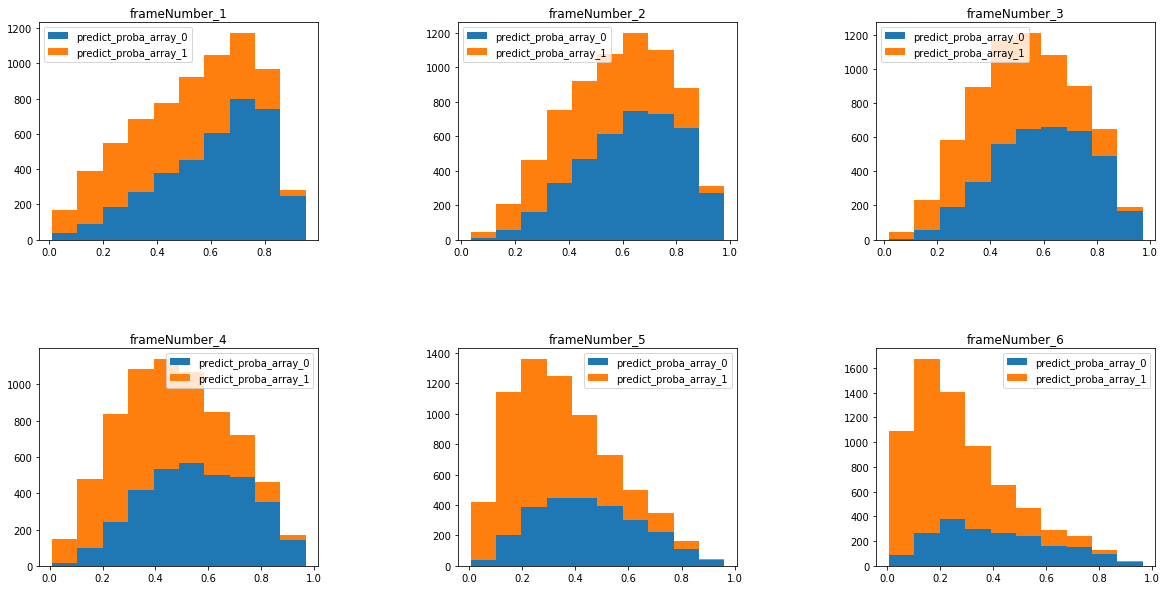

In [7]:
"""
上のセルで学習したclfを用いて色々と解析する。
今このセルで行なっている解析は
1. 各labelについて正解率を計算
2. 最適化された結果の切片および各係数を表示
3. テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成

"""
# 描画用の枠を用意

plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

# 回収率計算用に、[predict_proba_array, test_t]を各要素にもつリストを作成
predict_proba_array_list = []

# 正解率の計算などのため、train data, test dataそれぞれについて、特徴量部分のarrayとlabel部分のarrayを作成
train_x = train_data[:, :-num_labels]
test_x = test_data[:, :-num_labels]

for i, clf in enumerate(clf_list):
    train_t = train_data[:, - num_labels + i]
    test_t = test_data[:, - num_labels + i]
    
    # 正解率を計算
    train_score = clf.score(train_x, train_t)
    test_score = clf.score(test_x, test_t)
    print("{2}号艇についてtrainデータを使った正解率は{0},\n \
          testデータを使った正解率は{1}".format(train_score, test_score, i + 1))

    # 最適化された結果の切片と重みを取得
    intercept =clf.intercept_
    coef = clf.coef_
    print("切片は{0}".format(intercept))
    # for j in range (coef.shape[1]):
        # print(fv_list[j], coef[0, j], "\n")

    # テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成
    predict_proba_array = clf.predict_proba(test_x)
    
    # listに格納しておく
    predict_proba_array_list.append(predict_proba_array[:, 1])

    # 結果が1 (1枠が一着 , 2枠以降が3着以内) だったものの推定確率
    predict_proba_array_1 = predict_proba_array[:, 1][test_t==1]

    # 結果が0 (1枠以外が一着, 1枠以外の場合は4着以降) だったものの推定確率
    predict_proba_array_0 = predict_proba_array[:, 1][test_t==0]

    # 積み上げヒストグラムを作成
    title = "frameNumber_{0}".format(i + 1)
    labels = {'predict_proba_array_1', 'predict_proba_array_0'}
    plt.subplot(2, 3, i+1)
    plt.hist([predict_proba_array_1, predict_proba_array_0], histtype="barstacked", label=labels)
    plt.title(title)
    plt.legend()
plt.show()

In [ ]:
# my module
import loader
import exhibition_crawler
import race_list_crawler

# 各動作間の待ち時間（秒）
INTERVAL = 3


def convert_class_into_int(input_df):
    """
    クラスカラムを，A1 =0, A2 = 1のように数字に変換する

    :param input_df:
    :return:
    """

    class_dict = {"A1": 0, "A2": 1, "B1": 2, "B2": 3}

    for key, value in class_dict.items():
        input_df.replace(key, value, inplace=True)

    return input_df


def voting_algolithm_1(predict_proba_all, threshold_1, threshold_2, threshold_3):
    """
    1を頭に、x_2以上+x_3以上の組み合わせBOX買い（x_2v > x_3)
    :param predict_proba_all:
    :param threshold_1:
    :param threshold_2:
    :param threshold_3:
    :return:
    """

    voting_number_list = []

    if predict_proba_all[0] > threshold_1:
        for j in range(2, 7):
            if predict_proba_all[j - 1] > threshold_2:
                for k in range(2, 7):
                    if k is not j and predict_proba_all[k - 1] > threshold_3:
                        bet_num_1 = "1-{0}-{1}".format(j, k)
                        bet_num_2 = "1-{0}-{1}".format(k, j)
                        voting_number_list.append(bet_num_1)
                        voting_number_list.append(bet_num_2)

    voting_number_set = set(voting_number_list)
    voting_number_list = list(voting_number_set)

    return voting_number_list


def voting_algolithm_2(predict_proba_all, threshold_1, threshold_2, threshold_3):
    """
    2-1-iの組み合わせを買い
    :param predict_proba_all:
    :param threshold_1:
    :param threshold_2:
    :param threshold_3:
    :return:
    """

    voting_number_list = []

    if predict_proba_all[0] > threshold_1:
        if predict_proba_all[1] > threshold_2:
            for k in range(3, 7):
                if predict_proba_all[k - 1] > threshold_3:
                    voting_number_list.append("2-1-{0}".format(k))

    return voting_number_list



def main(rno, jcd, hd):

    venue_list = ["　津　", "三　国", "下　関", "丸　亀", "住之江",
                  "児　島", "唐　津", "多摩川", "大　村", "宮　島",
                  "尼　崎", "常　滑", "平和島", "徳　山", "戸　田",
                  "桐　生", "江戸川", "浜名湖", "琵琶湖", "福　岡",
                  "芦　屋", "若　松", "蒲　郡", "鳴　門"]

    # race_listから取れるデータを取得
    the_motor_and_boat_df = race_list_crawler.main(rno, jcd, hd)
    # racer dfをload
    racer_df = loader.load_racer_data()

    # 解析用dfへ変換する元のjsonを作成
    for_analysis_dict = {}
    for i in range(1, 7):
        racer_row = pd.merge(the_motor_and_boat_df, racer_df, how="left",
                             left_on=["racer_{0}".format(i), "racer_id_{0}".format(i)],
                             right_on=["racerName_ch", "racerId"]
                             )
        for_analysis_dict["class_{0}".format(i)] = [racer_row["class"].values[0]]
        for_analysis_dict["aveST_frame{0}".format(i)] = [racer_row["aveST_frame{0}".format(i)].values[0]]
        # 全国勝率・二連・三連率
        for_analysis_dict["win_rate_national_{0}".format(i)] = the_motor_and_boat_df["win_rate_national_{0}".format(i)]
        for_analysis_dict["place2Ratio_national_{0}".format(i)] = the_motor_and_boat_df["place2Ratio_national_{0}".format(i)]
        for_analysis_dict["place3Ratio_national_{0}".format(i)] = the_motor_and_boat_df["place3Ratio_national_{0}".format(i)]
        # 勝率・二連率・三連率（当地）
        for_analysis_dict["win_rate_local_{0}".format(i)] = the_motor_and_boat_df["win_rate_local_{0}".format(i)]
        for_analysis_dict["place2Ratio_local_{0}".format(i)] = the_motor_and_boat_df["place2Ratio_local_{0}".format(i)]
        for_analysis_dict["place3Ratio_local_{0}".format(i)] = the_motor_and_boat_df["place3Ratio_local_{0}".format(i)]

        # モーターおよびボートの成績
        for_analysis_dict["motor_place2Ratio_{0}".format(i)] = float(the_motor_and_boat_df["motor_place2Ratio_{0}".format(i)][0][1:])
        for_analysis_dict["motor_place3Ratio_{0}".format(i)] = float(the_motor_and_boat_df["motor_place3Ratio_{0}".format(i)][0][1:])
        for_analysis_dict["boat_place2Ratio_{0}".format(i)] = float(the_motor_and_boat_df["boat_place2Ratio_{0}".format(i)][0][1:])
        for_analysis_dict["boat_place3Ratio_{0}".format(i)] = float(the_motor_and_boat_df["boat_place3Ratio_{0}".format(i)][0][1:])

    for venue in venue_list:
        if venue == jcd:
            for_analysis_dict["{0}".format(venue)] = 1
        else:
            for_analysis_dict["{0}".format(venue)] = 0

    # dfに格納
    for_analysis_df = pd.DataFrame(for_analysis_dict)
    pd.set_option("display.max_columns", 500)
    # クラスカラムを，A1 =0, A2 = 1のように数字に変換する
    for_analysis_df = convert_class_into_int(for_analysis_df)

    # dfをfloatに変換
    for_analysis_df = for_analysis_df.astype(float)

    # inputに用いることができるarrayに直す
    x = for_analysis_df.values

    # ラベルが1になる確率を1号艇から6号艇の順に並べたリスト
    predict_proba_all = []
    for i, clf in enumerate(clf_list):
        predict_proba_all.append(clf.predict_proba(x)[0][1])

    print(predict_proba_all)

    # 投票するリストを作成 (1頭でx_2を超えたやつとx_3を超えたやつの組み合わせbox
    voting_number_list_1 = voting_algolithm_1(predict_proba_all, 0.6, 0.8, 0.7)
    voting_number_list_2 = voting_algolithm_2(predict_proba_all, 0.5, 0.8, 0.6)
    voting_number_list = voting_number_list_1 + voting_number_list_2
    print(voting_number_list)

    return voting_number_list


if __name__ == "__main__":

    #### 下記inputを指定して実行 ###
    """
    注意点
    1. その場でcrawlするため、開始直前のレースに対してしか適用できない
    2. 以下のレース場に関しては、boatraceBBのサイトが無いため利用不可
    (inputしても自動的にpassになる）
        ["蒲　郡", "平和島", "鳴　門", "下　関", "　津　"]
    
    """
    # ----------input------------
    the_rno = "11R"
    the_jcd = "桐　生"
    the_hd = "2019/10/21"

    # ---------------------------

    the_voting_number_list = main(the_rno, the_jcd, the_hd)